# Additional Tasks

### Import Neccessary Libraries

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


### Data Loading and Preprocessing

In [11]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['test', 'validation', 'train'],
    shuffle_files=True,
    as_supervised=True,  # Include labels
    with_info=True
)
print(f"Dataset Info:\n{ds_info}")
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Dataset Info:
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/da

In [12]:
IMG_SIZE = 224  # You can adjust this size
BATCH_SIZE = 64  # You can adjust this size

def preprocess(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0,1]
    return image, label


In [13]:
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_unbatched = ds_train
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Load Model

In [14]:
loaded_model = keras.models.load_model('flower_classification_model.keras')
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(ds_test)
print(f'Loaded Model Test Accuracy: {loaded_test_accuracy*100:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 666ms/step - accuracy: 0.7103 - loss: 1.3735
Loaded Model Test Accuracy: 69.8039


## Using Few-shot learning

### Reduce training data

In [15]:
subset_fraction = 0.25 # Fraction of the training data to use
ds_train_subset = ds_train.take(int(len(ds_train) * subset_fraction))

### Training

In [16]:
# Reinitialize the model (to ensure fair comparison)
model_subset = models.clone_model(loaded_model)
model_subset.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True),
]

In [ ]:
# Train on subset
epochs = 250  # Adjust the number of epochs as needed

history_subset = model_subset.fit(
    ds_train_subset,
    validation_data=ds_val,
    epochs=epochs,
    callbacks=callbacks
)

24/24 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.0128 - loss: 5.5330 - val_accuracy: 0.0098 - val_loss: 4.6418


In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

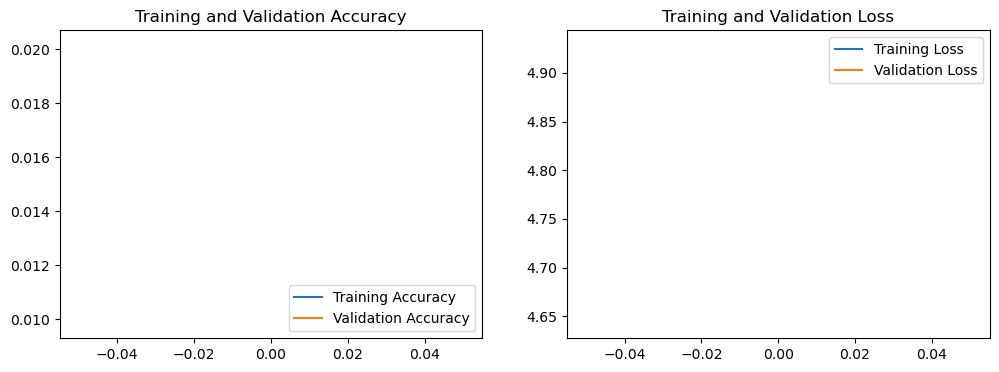

In [20]:
plot_history(history_subset)

### Evaluation

In [21]:
# Evaluate
test_loss, test_accuracy = model_subset.evaluate(ds_test)
print(f"Test Accuracy with {int(subset_fraction*100)}% training data: {test_accuracy*100:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 690ms/step - accuracy: 0.0116 - loss: 4.6330
Test Accuracy with 25% training data: 0.9804


## Using MixUp

### Applying mixup to training data

In [22]:
def mixup(ds, alpha=0.2):
    def mixup_batch(images, labels):
        batch_size = tf.shape(images)[0]
        indices = tf.random.shuffle(tf.range(batch_size))
        
        shuffled_images = tf.gather(images, indices)
        shuffled_labels = tf.gather(labels, indices)
        
        lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size])
        lam_x = tf.reshape(lam, (batch_size, 1, 1, 1))
        
        mixed_images = images * lam_x + shuffled_images * (1 - lam_x)
        mixed_labels = tf.cast(labels, tf.float32) * lam + tf.cast(shuffled_labels, tf.float32) * (1 - lam)
        
        return mixed_images, mixed_labels
    
    return ds.map(lambda images, labels: mixup_batch(images, labels), num_parallel_calls=tf.data.AUTOTUNE)

# Apply mixup to the training data
ds_train_mixup = mixup(ds_train)


### Training

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True),
]

In [24]:
# Compile the model with categorical crossentropy
model_mixup = models.clone_model(loaded_model)
model_mixup.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 250  # Adjust the number of epochs as needed

history_mixup = model_mixup.fit(
    ds_train_mixup,
    validation_data=ds_val,
    epochs=epochs,
    callbacks=callbacks
)

97/97 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.0014 - loss: 5.5301 - val_accuracy: 0.0098 - val_loss: 4.7469


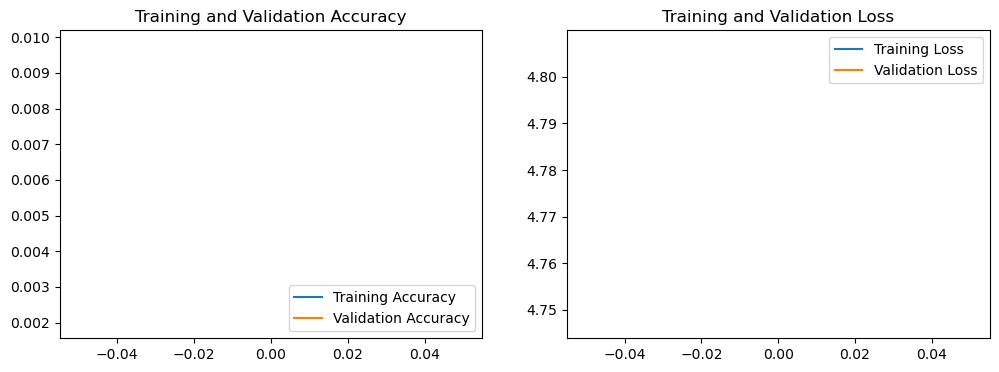

In [26]:
plot_history(history_mixup)

### Evaluation

In [27]:
# Evaluate
test_loss, test_accuracy = model_mixup.evaluate(ds_test)
print(f"Test Accuracy with MixUp training data: {test_accuracy*100:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 717ms/step - accuracy: 0.0105 - loss: 4.7368
Test Accuracy with MixUp training data: 0.9804
